# Geometric And Topological Feature Examples

This notebook shows examples of computing the different hand-designed features for shape analysis.

The dependencies are polyscope, scikit-image, nibabel, and pymeshlab

First, we'll load in one of the tumors as an example

In [1]:
%load_ext autoreload
%autoreload 2
import nibabel as nib
import numpy as np 
import matplotlib.pyplot as plt
from skimage import measure # For marching cubes
import polyscope as ps # For mesh display
import pandas as pd
import os
import sys
import skimage
import skimage.io
sys.path.append("../src")
import glob
from geomstats import *


def load_dictionary(metadata_path):
    df = pd.read_csv(metadata_path)
    data = {}
    for index, row in df.iterrows():
        patient_id = row["ID"]
        patient_id = "M-0".join(patient_id.split("M-")) #File paths have an extra 0 in ID
        data[patient_id] = row
    del data["UCSF-PDGM-0541"] # Skip Patient 541 because segmentation file is empty
    return data

def argsort(seq):
    return np.array(sorted(range(len(seq)), key=seq.__getitem__), dtype=int)

metadata_path = "../Data/UCSF-PDGM-metadata_v2.csv"
all_data_path = "../Data/UCSF-PDGM-v3"
data = load_dictionary(metadata_path) 

patients = list(data.keys())
diagnosis = [data[p]["Final pathologic diagnosis (WHO 2021)"] for p in patients]
dead = np.array([data[p]["1-dead 0-alive"] for p in patients])
# Sort by dead/alive first, then by diagnosis
idx = np.argsort(dead)
idx = idx[argsort([diagnosis[i] for i in idx])]
patients = [patients[i] for i in idx]

iso_names = {1:"Necrotic", 2:"Edema", 4:"Main Tumor"} # What the labels actually mean
iso_levels = [2, 4, 1] # Column order of the labels


# Pick out the first patient as an example
patient = os.listdir(all_data_path)[0]
patient_folder_path = os.path.join(all_data_path, patient)
patient = patient[:-6]

tumor_seg_path = patient_folder_path + "/" + patient_folder_path[-20:-6] + "_tumor_segmentation.nii.gz"
tumor_seg_nifti = nib.load(tumor_seg_path)
tumor_seg_mat = tumor_seg_nifti.get_fdata()


for k, level in enumerate(iso_levels):
    try:
        binary = tumor_seg_mat==level
        level_name = iso_names[level]
        data[patient]["count{}".format(level_name)] = np.sum(binary)
        data[patient]["V{}".format(level_name)], data[patient]["T{}".format(level_name)], _, _ = measure.marching_cubes(binary, 0.5)
    except:
        #print("Empty mesh", patient, iso_names[iso_levels[k]])
        data[patient]["V{}".format(level_name)] = np.array([])
        data[patient]["T{}".format(level_name)] = np.array([], dtype=int)


[polyscope] Backend: openGL3_glfw -- Loaded openGL version: 4.6 (Core Profile) Mesa 22.2.5


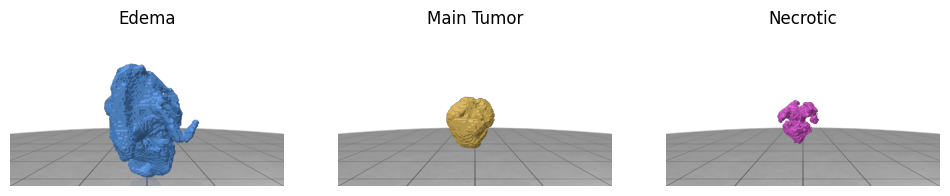

In [2]:
ps.init()
ps.remove_all_structures()
ps_all = []
res = 4
plt.figure(figsize=(3*res, res))
for i, name in enumerate(iso_levels):
    name = iso_names[name]
    V, T = data[patient]["V{}".format(name)], data[patient]["T{}".format(name)]
    V -= np.mean(V, axis=0, keepdims=True) # Center each mesh
    ps_i = ps.register_surface_mesh(name, V, T)
    for p in ps_all:
        p.set_enabled(False)
    ps.screenshot("temp.png")
    I = skimage.io.imread("temp.png")
    plt.subplot(1, 3, i+1)
    plt.imshow(I)
    plt.title(name)
    plt.axis("off")
    ps_all.append(ps_i)

# Rotation Invariant Geometric Features

## Shape Histograms

Ankerst 1999 "3D Shape Histograms for Similarity Search and Classification in Spatial Databases"


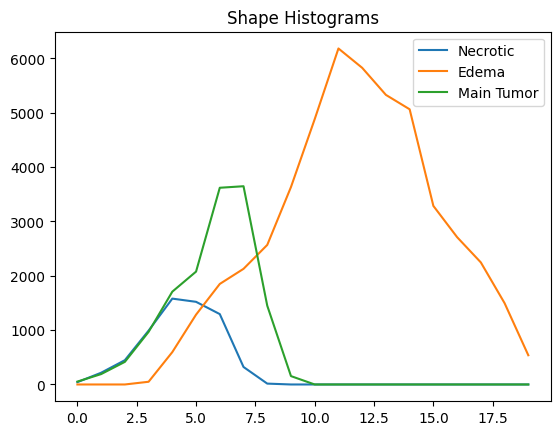

In [3]:
VEdema = data[patient]["VEdema"]
# Compute the maximum radius (NOTE: This should be done over all samples)
r_max = np.max(np.sqrt(np.sum(VEdema**2, axis=1)))
n_shells = 20
for name in iso_names.values():
    V = data[patient]["V{}".format(name)]
    h_shape = get_shape_hist(V, n_shells=n_shells, r_max=r_max)
    plt.plot(h_shape)
plt.legend(list(iso_names.values()))
plt.title("Shape Histograms");

## Shape Shell Histograms


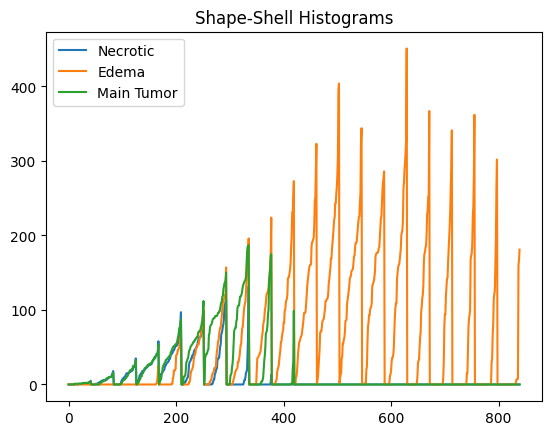

In [4]:
n_shells = 20
for name in iso_names.values():
    V = data[patient]["V{}".format(name)]
    h_shape = get_shape_shell_hist(V, n_shells=n_shells, r_max=r_max)
    plt.plot(h_shape)
plt.legend(list(iso_names.values()))
plt.title("Shape-Shell Histograms");

## Shape PCA Histograms

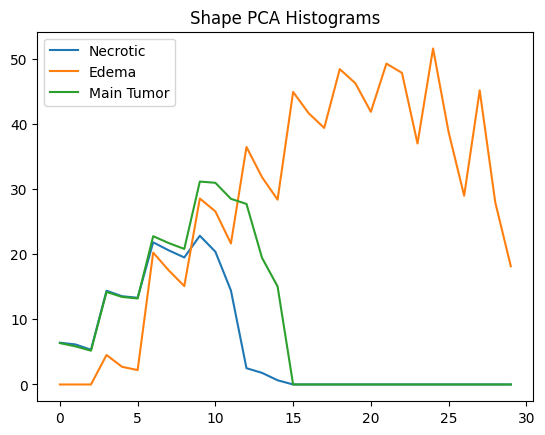

In [5]:
n_shells = 10
for name in iso_names.values():
    V = data[patient]["V{}".format(name)]
    h_shape = get_shape_pca_hist(V, n_shells=n_shells, r_max=r_max)
    plt.plot(h_shape)
plt.legend(list(iso_names.values()))
plt.title("Shape PCA Histograms");

## D2 Histogram

Osada 2002 "Shape Distributions"

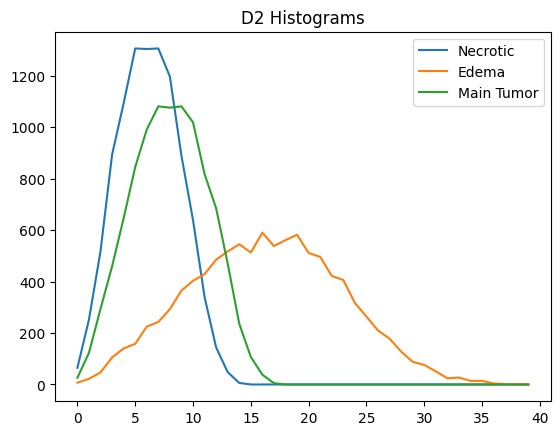

In [6]:
n_bins = 40 # Number of bins in the histogram between [0, d_max]
n_samples = 10000 # Number of random samples
for name in iso_names.values():
    V = data[patient]["V{}".format(name)]
    d = get_d2_hist(V, d_max=r_max*2, n_bins=n_bins, n_samples=n_samples)
    plt.plot(d)
plt.legend(list(iso_names.values()))
plt.title("D2 Histograms");

# A3 Histograms

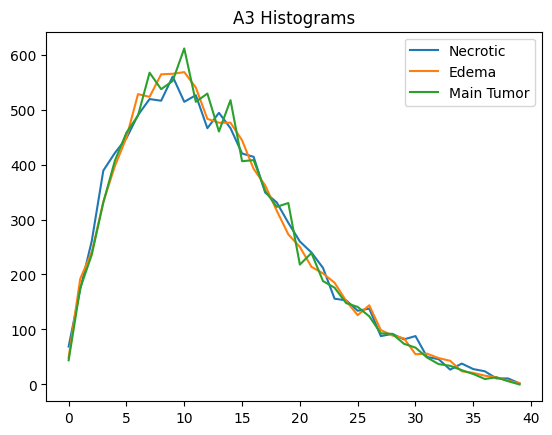

In [7]:
n_bins = 40 # Number of bins in the histogram between [0, PI]
n_samples = 10000 # Number of random samples
for name in iso_names.values():
    V = data[patient]["V{}".format(name)]
    a = get_a3_hist(V, n_bins=n_bins, n_samples=n_samples)
    plt.plot(a)
plt.legend(list(iso_names.values()))
plt.title("A3 Histograms");

## Extended Gaussian Images

Horn 1984: "Extended Gaussian Images"

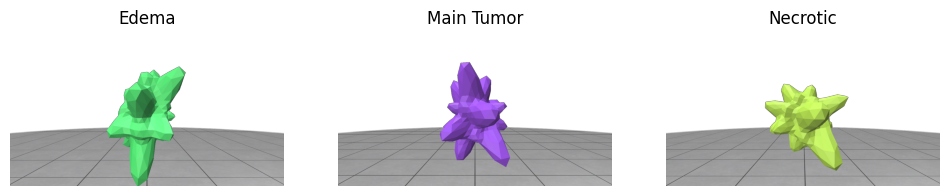

In [8]:
ps.remove_all_structures()
ps_all = []
res = 4
plt.figure(figsize=(3*res, res))
for i, name in enumerate(iso_levels):
    name = iso_names[name]
    V, T = data[patient]["V{}".format(name)], data[patient]["T{}".format(name)]
    hist, S, ST = get_egi(V, T, subdiv=3, sigma=np.pi/15)
    ## Note: S and ST are for visualization only; the descriptor is in "hist"
    ps_i = ps.register_surface_mesh("EGI{}".format(name), S, ST)
    for p in ps_all:
        p.set_enabled(False)
    if len(ps_all) == 0:
        ps.reset_camera_to_home_view()
    ps.screenshot("temp.png")
    I = skimage.io.imread("temp.png")
    plt.subplot(1, 3, i+1)
    plt.imshow(I)
    plt.title(name)
    plt.axis("off")
    ps_all.append(ps_i)

## Spin Images

Johnson 1997 "Spin-images: a representation for 3-D surface matching"

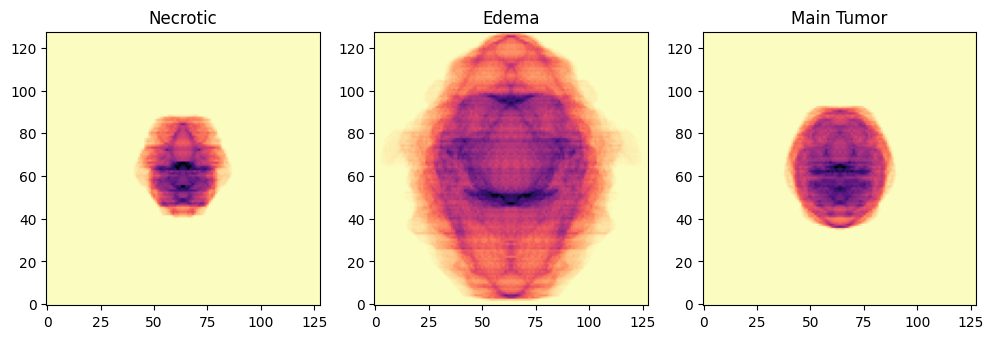

In [9]:
res = 4
plt.figure(figsize=(res*3, res))
n_angles = 50
dim = 128
for i, name in enumerate(iso_names.values()):
    V = data[patient]["V{}".format(name)]
    img = get_spin_image(V, n_angles, r_max, dim)
    plt.subplot(1, 3, i+1)
    plt.imshow(img, cmap='magma_r')
    plt.gca().invert_yaxis()
    plt.title(name)